In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

In [2]:
tf.__version__

'2.8.0'

### Basic Optimization with GradientTape

The beauty of TensorFlow 2 is in its simplicity. Basically, all you need to do is implement forward propagation through a computational graph. TensorFlow will compute the derivatives for you, by moving backwards through the graph recorded with GradientTape. All that's left for you to do then is specify the cost function and optimizer you want to use!

When writing a TensorFlow program, the main object to get used and transformed is the tf.Tensor. These tensors are the TensorFlow equivalent of Numpy arrays, i.e. multidimensional arrays of a given data type that also contain information about the computational graph.

Below, you'll use tf.Variable to store the state of your variables. Variables can only be created once as its initial value defines the variable shape and type. Additionally, the dtype arg in tf.Variable can be set to allow data to be converted to that type. But if none is specified, either the datatype will be kept if the initial value is a Tensor, or convert_to_tensor will decide. It's generally best for you to specify directly, so nothing breaks!

In [3]:
train_dataset = h5py.File("dataset/train_signs.h5")
test_dataset = h5py.File("dataset/test_signs.h5")

In [4]:
train_dataset["train_set_x"]

<HDF5 dataset "train_set_x": shape (1080, 64, 64, 3), type "|u1">

In [5]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset["train_set_x"])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset["train_set_y"])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset["test_set_x"])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset["test_set_y"])

In [6]:
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

Since TensorFlow Datasets are generators, you can't access directly the contents unless you iterate over them in a for loop, or by explicitly creating a Python iterator using iter and consuming its elements using next. Also, you can inspect the shape and dtype of each element using the element_spec attribute.

In [7]:
print(x_train.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [8]:
x_train

<TensorSliceDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)>

In [9]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [10]:
i = 0
for element in x_train:
#     print(element)
    i = i + 1
#     break
print(i)

1080


There's one more additional difference between TensorFlow datasets and Numpy arrays: If you need to transform one, you would invoke the map method to apply the function passed as an argument to each of the elements.

In [11]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 256.
    image = tf.reshape(image, [-1, 1])
    return image

In [12]:
new_train = x_train.map(normalize)
new_test = y_train.map(normalize)

In [13]:
new_train.element_spec

TensorSpec(shape=(12288, 1), dtype=tf.float32, name=None)

In [14]:
print(next(iter(new_train)))

tf.Tensor(
[[0.88671875]
 [0.859375  ]
 [0.8359375 ]
 ...
 [0.8125    ]
 [0.81640625]
 [0.81640625]], shape=(12288, 1), dtype=float32)


2022-04-13 00:44:59.468279: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Linear Function
Note that the difference between tf.constant and tf.Variable is that you can modify the state of a tf.Variable but cannot change the state of a tf.constant.

In [15]:
def linear_function():
    np.random.seed(1)
    X = tf.constant(np.random.randn(3, 1))
    W = tf.constant(np.random.randn(4, 3))
    b = tf.constant(np.random.randn(4, 1))
    Y = tf.add(tf.matmul(W, X), b)
    
    return Y

In [16]:
result = linear_function()
print(result)

assert type(result) == EagerTensor, "Use the TensorFlow API"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92mAll test passed")

tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
All test passed


### Computing the Sigmoid

In [17]:
def sigmoid(z):
    
    z = tf.cast(z, tf.float32)
    a = tf.keras.activations.sigmoid(z)
    return a

In [18]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

def sigmoid_test(target):
    result = target(0)
    assert(type(result) == EagerTensor)
    assert (result.dtype == tf.float32)
    assert sigmoid(0) == 0.5, "Error"
    assert sigmoid(-1) == 0.26894143, "Error"
    assert sigmoid(12) == 0.9999939, "Error"

    print("\033[92mAll test passed")

sigmoid_test(sigmoid)

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.9999939, shape=(), dtype=float32)
All test passed


### Using One Hot Encoder

In [19]:
def one_hot_matrix(label, depth=6):
    
    """ label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take
    """
    one_hot = tf.one_hot(label, depth, axis=0)
    one_hot = tf.reshape(one_hot,[depth,1])
    return one_hot

In [20]:
one_hot_matrix(tf.constant(2), depth=6)

<tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [21]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [22]:
new_y_train

<MapDataset element_spec=TensorSpec(shape=(6, 1), dtype=tf.float32, name=None)>

In [23]:
print(next(iter(new_y_test)))

tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(6, 1), dtype=float32)


### Initialize the Parameters

In [24]:
def initialize_parameters():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   
    #(approx. 6 lines of code)
    W1 = tf.Variable(initializer(shape=(25, 12288)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6,12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [25]:
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


In [26]:
parameters = initialize_parameters()

## Building Your First Neural Network in TensorFlow
* Implement forward propagation
* Retrieve the gradients and train the model

One of TensorFlow's great strengths lies in the fact that you only need to implement the forward propagation function.

Here, you'll use a TensorFlow decorator, @tf.function, which builds a computational graph to execute the function. @tf.function is polymorphic, which comes in very handy, as it can support arguments with different data types or shapes, and be used with other languages, such as Python. This means that you can use data dependent control flow statements.

When you use @tf.function to implement forward propagation, the computational graph is activated, which keeps track of the operations. This is so you can calculate your gradients with backpropagation.

### forward_propagation

In [27]:
@tf.function
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #(approx. 5 lines)                   # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)    # Z1 = np.dot(W1, X) + b1
    A1 = tf.keras.activations.relu(Z1) # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)   # Z2 = np.dot(W2, A1) + b2
    A2 = tf.keras.activations.relu(Z2) # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)   # Z3 = np.dot(W3, A2) + b3
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    
    return Z3

In [28]:
def forward_propagation_test(target, examples):
    for batch in examples:
        forward_pass = target(batch, parameters)
        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 1), "Last layer must use W3 and b3"
        assert np.any(forward_pass < 0), "Don't use a ReLu layer at end of your network"
        assert np.allclose(forward_pass, 
                           [[-0.13082162],
                           [ 0.21228778],
                           [ 0.7050022 ],
                           [-1.1224034 ],
                           [-0.20386729],
                           [ 0.9526217 ]]), "Output does not match"
        print(forward_pass)
        break
    

    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_train)

AssertionError: Output does not match

## Compute the Cost

In [29]:
@tf.function
def compute_cost(logits, labels):
    
    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(labels, logits, from_logits=True))
    
    return cost

In [30]:
def compute_cost_test(target):
    labels = np.array([[0., 1.], [0., 0.], [1., 0.]])
    logits = np.array([[0.6, 0.4], [0.4, 0.6], [0.4, 0.6]])
    result = compute_cost(logits, labels)
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.7752516 +  0.9752516 + 0.7752516) / 3.0) < 1e-7), "Test does not match. Did you get the mean of your cost functions?"

    print("\033[92mAll test passed")

compute_cost_test(compute_cost)

tf.Tensor(0.8419182681095858, shape=(), dtype=float64)
All test passed


### what is memory bottleneck?
A memory bottleneck refers to a memory shortage due to insufficient memory, memory leaks, defective programs or when slow memory is used in a fast processor system. A memory bottleneck affects the machine's performance by slowing down the movement of data between the CPU and the RAM.

In [40]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
         num_epochs=1500, minibatch_size=32, print_cost=True):
    costs = []
    parameters = initialize_parameters()
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    
    # If your program depends on the batches having the same outer dimension, 
    # you should set the drop_remainder argument to True to prevent the smaller batch from being produced.


    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8)
    
    for epoch in range(num_epochs):
        
        epoch_cost = 0.
        
        for (minibatch_X, minibatch_Y) in zip(X_train, Y_train):
            with tf.GradientTape() as tape:
                Z3 = forward_propagation(minibatch_X, parameters)
                minibatch_cost = compute_cost(Z3, minibatch_Y)
                
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost / minibatch_size
        
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))            
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Save the parameters in a variable
    print ("Parameters have been trained!")

    return parameters
    

Cost after epoch 0: 0.649044
Cost after epoch 10: 0.604877
Cost after epoch 20: 0.582356
Cost after epoch 30: 0.564854
Cost after epoch 40: 0.549586
Cost after epoch 50: 0.536739
Cost after epoch 60: 0.526052
Cost after epoch 70: 0.516995
Cost after epoch 80: 0.509201
Cost after epoch 90: 0.502472
Cost after epoch 100: 0.496593
Cost after epoch 110: 0.491454
Cost after epoch 120: 0.486965
Cost after epoch 130: 0.483026
Cost after epoch 140: 0.479581
Cost after epoch 150: 0.476558
Cost after epoch 160: 0.473880
Cost after epoch 170: 0.471527
Cost after epoch 180: 0.469446
Cost after epoch 190: 0.467602


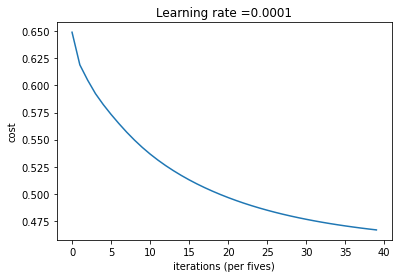

Parameters have been trained!


{'W1': <tf.Variable 'Variable:0' shape=(25, 12288) dtype=float32, numpy=
 array([[-0.00362652, -0.00460723,  0.01456246, ...,  0.01382768,
          0.00927871, -0.00812915],
        [-0.00593991, -0.01676408,  0.00527415, ...,  0.00828636,
         -0.00292361,  0.00013131],
        [ 0.00843046,  0.00052047,  0.01484262, ...,  0.00863219,
          0.02275358,  0.00342402],
        ...,
        [-0.00456412,  0.02391429, -0.01242701, ..., -0.01059515,
          0.00634554,  0.00828285],
        [-0.02008474, -0.01066575, -0.00202228, ..., -0.00574484,
          0.02609658,  0.01006267],
        [-0.00645422, -0.00461257,  0.02176875, ..., -0.00292949,
         -0.00284526,  0.01450794]], dtype=float32)>,
 'b1': <tf.Variable 'Variable:0' shape=(25, 1) dtype=float32, numpy=
 array([[-0.2571621 ],
        [-0.05700606],
        [-0.2515691 ],
        [ 0.1899629 ],
        [ 0.3159076 ],
        [ 0.17147051],
        [ 0.48490408],
        [ 0.0573285 ],
        [-0.36292887],
        

In [41]:
model(new_train, new_y_train, new_test, new_y_test, num_epochs=200)


In this assignment, you were introducted to tf.GradientTape, which records operations for differentation. 

* Used tf.Variable to modify your variables
* Applied TensorFlow decorators and observed how they sped up your code
* Trained a Neural Network on a TensorFlow dataset
* Applied batch normalization for a more robust network